In [32]:
import os
from pprint import pprint
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["font.size"] = 18

from quvac.utils import write_yaml, read_yaml

SCRIPT_PATH = '../src/quvac/simulation.py'

## Run simulation
For better management, the calculation of transition amplitudes is separated from
subsequent postprocessing (calculation of observables, e.g. total or 
polarization-resolved signal). The simulation script by default calculates the amplitudes 
and DOES postprocessing.

Here we run script to only calculate transition amplitudes.

### Create initialization yaml file

In [2]:
lam = 800e-9
w0 = 2 * lam
tau = 25e-15

# all parameters in SI units
field_1_params = {
    "field_type": "paraxial_gaussian_maxwell",
    "focus_x": [0.,0.,0.],
    "focus_t": 0.,
    "theta": 0,
    "phi": 0,
    "beta": 0,
    "phase0": 0,
    "lam": lam,
    "w0": w0,
    "tau": tau,
    "W": 25,
    "order": 0,
}

# add counter-propagating field
field_2_params = {
    "field_type": "paraxial_gaussian_maxwell",
    "focus_x": [0.,0.,0.],
    "focus_t": 0.,
    "theta": 180,
    "phi": 0,
    "beta": 0,
    "phase0": 0,
    "lam": lam,
    "w0": w0,
    "tau": tau,
    "W": 25,
    "order": 0,
}

# combine
fields_params = {
    "field_1": field_1_params,
    "field_2": field_2_params,
}

# grid parameters
grid_params = {
    'mode': 'dynamic',
    'collision_geometry': 'z',
    'transverse_factor': 20,
    'longitudinal_factor': 8,
    'time_factor': 4,
    'spatial_resolution': 1,
    'time_resolution': 1,
}

ini_data = {
    'mode': 'simulation',
    'fields': fields_params,
    'grid': grid_params,
    'integrator': {
        'type': 'vacuum_emission',
    }
}

path = "../data/tutorials"
Path(path).mkdir(parents=True, exist_ok=True)
ini_file = os.path.join(path, 'ini.yaml')

write_yaml(ini_file, ini_data)

## Launch script
Depending on the settings of your jupyter lab and environment manager,
one of two should work:
1) Launching from jupyter sub-terminal with `os.system`.
2) Launching with environment manager.

If it still doesn't work, you could, of course, launch the specified command directly 
from the command line.

In [ ]:
# Method 1
status = os.system(f"{SCRIPT_PATH} --input {ini_file}")

In [3]:
# Method 2
import subprocess

env_name = "test-quvac"
micromamba_exe = "/home/<your_username>/.local/bin/micromamba"

result = subprocess.run(
    [micromamba_exe, "run", "-n", env_name, SCRIPT_PATH, "--input", ini_file],
    capture_output=True, text=True
)
print(result.stdout)  # Print script output
print(result.stderr) 


Timings:
Field setup:                        1.68 s
Vacem setup:                        0.00 s
Amplitudes calculation:            50.90 s
    Per time step:                  0.23 s
Postprocess:                        0.01 s
----------------------------------------------------
Total:                             52.59 s

Memory (max usage):
Amplitudes calculation:          313.00 MB
Total:                           313.00 MB

Simulation finished!




## Run simulation with postprocessing

In [5]:
ini_data = {
    'mode': 'simulation_postprocess',
    'fields': fields_params,
    'grid': grid_params,
    'integrator': {
        'type': 'vacuum_emission',
    },
    'postprocess': {
        'perp_polarization_type': 'optical axis',
        'perp_field_idx': 1,
    }
}

path = "../data/tutorials"
Path(path).mkdir(parents=True, exist_ok=True)
ini_file = os.path.join(path, 'ini.yaml')

write_yaml(ini_file, ini_data)

In [6]:
env_name = "test-quvac"
micromamba_exe = "/home/<your_username>/.local/bin/micromamba"

result = subprocess.run(
    [micromamba_exe, "run", "-n", env_name, SCRIPT_PATH, "--input", ini_file],
    capture_output=True, text=True
)
print(result.stdout)  # Print script output
print(result.stderr) 


Timings:
Field setup:                        1.04 s
Vacem setup:                        0.00 s
Amplitudes calculation:            51.03 s
    Per time step:                  0.23 s
Postprocess:                        0.11 s
----------------------------------------------------
Total:                             52.18 s

Memory (max usage):
Amplitudes calculation:          313.19 MB
Total:                           313.19 MB

Simulation finished!




Notice that after successfull completion of simulation, in the directory where
`ini.yaml` file is, result files were created:
* amplitudes.npz
* spectra_total.npz
* spectra_polarization.npz
* simulation_postprocess_performance.yml
* simulation_postprocess.log

## Check contents of files

In [11]:
mode = "simulation_postprocess"

log_file = os.path.join(path, f"{mode}.log")
performance_file = os.path.join(path, f"{mode}_performance.yml")
amplitudes_file = os.path.join(path, f"amplitudes.npz")
post_total_file = os.path.join(path, f"spectra_total.npz")
post_polarization_file = os.path.join(path, f"spectra_polarization.npz")

In [12]:
# log contains important settings and steps during the simulation
with open(log_file, "r") as f:
    data = f.read()
print(data)


####################################################
Start of simulation:    Mon Mar  3 16:05:47 2025
####################################################

Using float64 precision

Grid:
Space

Number of points (x,y,z):              (39, 39, 256)
Box for x axis:               (-16.00, 16.00) micron
Box for y axis:               (-16.00, 16.00) micron
Box for z axis:               (-29.98, 29.75) micron
----------------------------------------------------
Time

Number of points:                                225
Box:                              (-50.00, 50.00) fs

MILESTONE: Grids are created

Field constructor:
ExternalField
----------------------------------------------------
Setting up field 1:
    paraxial_gaussian_maxwell: GaussianAnalytic
    Energy after projection in k-space: 24.841 J
    Energy after "correction":          25.000 J
Setting up field 2:
    paraxial_gaussian_maxwell: GaussianAnalytic
    Energy after projection in k-space: 24.841 J
    Energy after "correction

In [18]:
# performance file contains timings and used memory
performance = read_yaml(performance_file)
pprint(performance)

{'memory': {'maxrss_amplitudes': 320708, 'maxrss_total': 320708},
 'timings': {'amplitudes': 20303.58774974,
             'field_setup': 20252.558236454,
             'integral': 50.52479767099794,
             'per_iteration': 0.2267978368266712,
             'postprocess': 20303.698557065,
             'start': 20251.519768575,
             'total': 52.17878849000044,
             'vacem_setup': 20252.559080516}}


In [24]:
# contains complex amplitudes S1 and S2 + (x,y,z) grid
amplitudes = np.load(amplitudes_file)
print(list(amplitudes.keys()))

['x', 'y', 'z', 'S1', 'S2']


['kx', 'ky', 'kz', 'N_xyz', 'N_total']
Total signal: 26.33


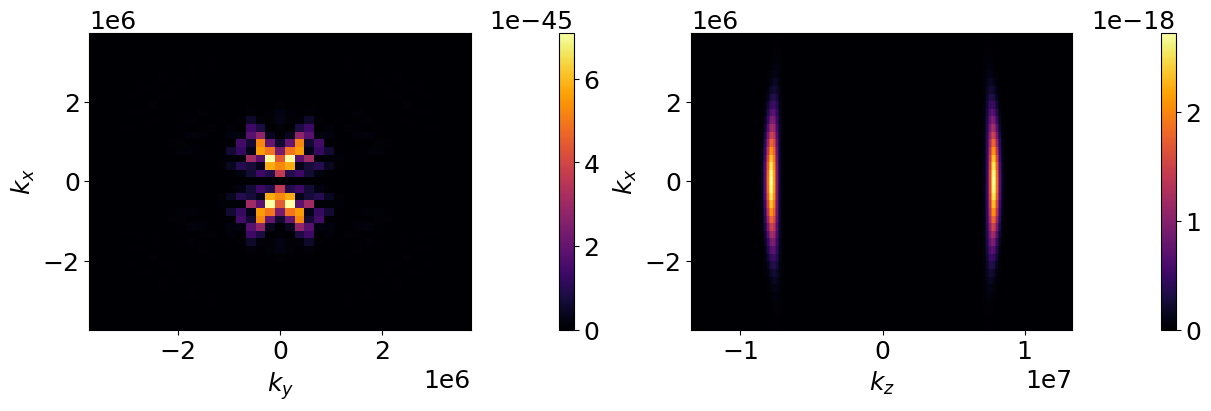

In [35]:
# contains total signal observables
post_total = np.load(post_total_file)
print(list(post_total.keys()))

print(f"Total signal: {post_total["N_total"]:.2f}")

kx, ky, kz, N_xyz = [post_total[key] for key in "kx ky kz N_xyz".split()]
nx, ny, nz = N_xyz.shape 

# plot total signal spectral distribution on a cartesian grid
plt.figure(figsize=(12,4), layout='constrained')
plt.subplot(1,2,1)
plt.pcolormesh(ky, kx, N_xyz[:,:,nz//2], cmap='inferno')
plt.colorbar()
plt.xlabel("$k_y$")
plt.ylabel("$k_x$")

plt.subplot(1,2,2)
plt.pcolormesh(kz, kx, N_xyz[:,ny//2,:], cmap='inferno')
plt.colorbar()
plt.xlabel("$k_z$")
plt.ylabel("$k_x$")
plt.show()

In [36]:
# contains polarization signal observables
post_polarization = np.load(post_polarization_file)
print(list(post_polarization.keys()))

['kx', 'ky', 'kz', 'epx', 'epy', 'epz', 'efx', 'efy', 'efz', 'Np_xyz', 'Np_total']
